Loading FastText sentence embeddings and labels...
Loaded 15000 samples with 300-dim FastText features.
Categories: ['economic', 'environment', 'health', 'politic', 'sport', 'technology']
Training set: 12000 samples
Test set: 3000 samples

Training models on FastText features

Training and evaluating SVM (FastText)...
CV accuracies: [0.67041667 0.65041667 0.64208333 0.67541667 0.62958333]
Mean CV accuracy: 0.6536 (±0.0172)
Training accuracy: 0.6648
Training completed in 658.29 seconds
SVM (FastText) model saved
Test Accuracy: 0.6713
Test Precision: 0.8072
Test Recall: 0.6713
Test F1 Score: 0.6390


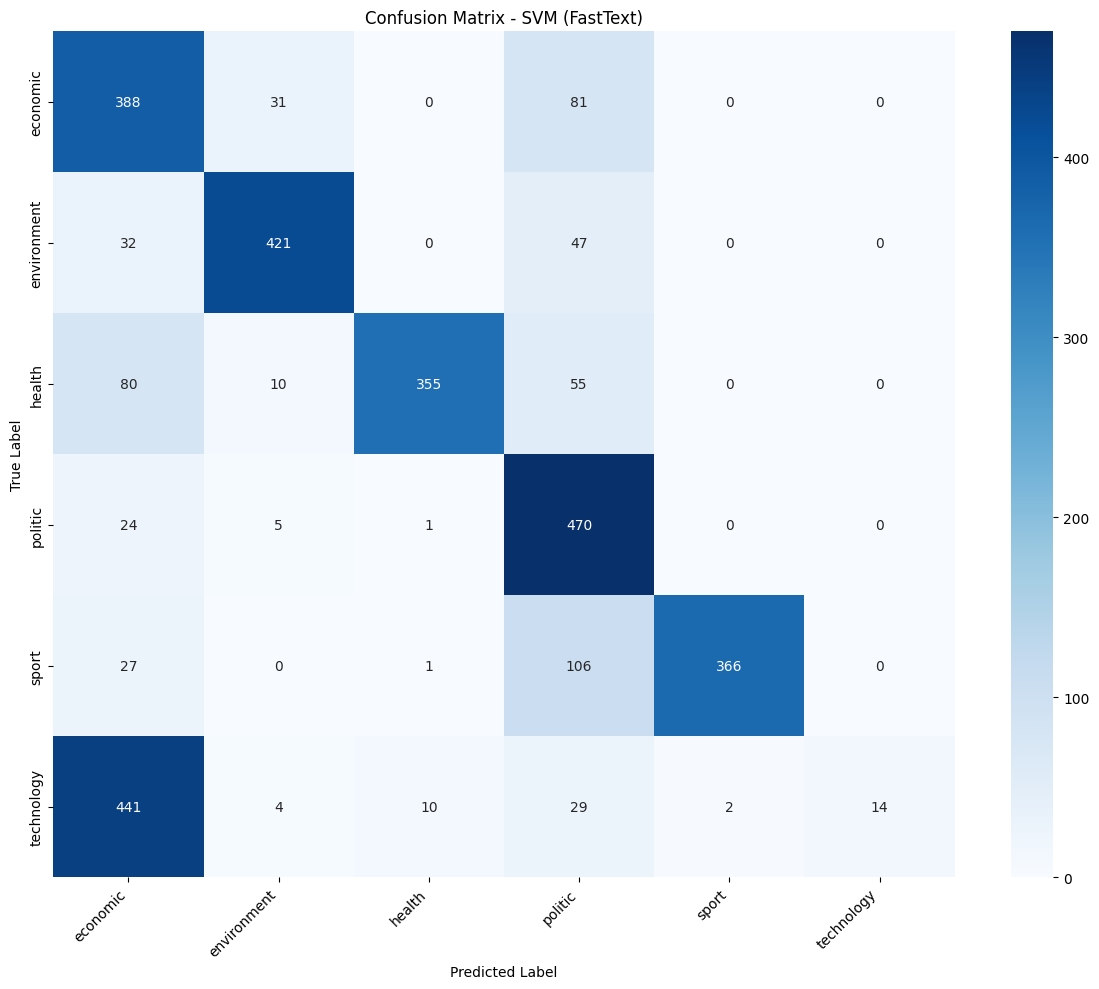


Classification Report:
              precision    recall  f1-score   support

    economic       0.39      0.78      0.52       500
 environment       0.89      0.84      0.87       500
      health       0.97      0.71      0.82       500
     politic       0.60      0.94      0.73       500
       sport       0.99      0.73      0.84       500
  technology       1.00      0.03      0.05       500

    accuracy                           0.67      3000
   macro avg       0.81      0.67      0.64      3000
weighted avg       0.81      0.67      0.64      3000


Generating learning curves...


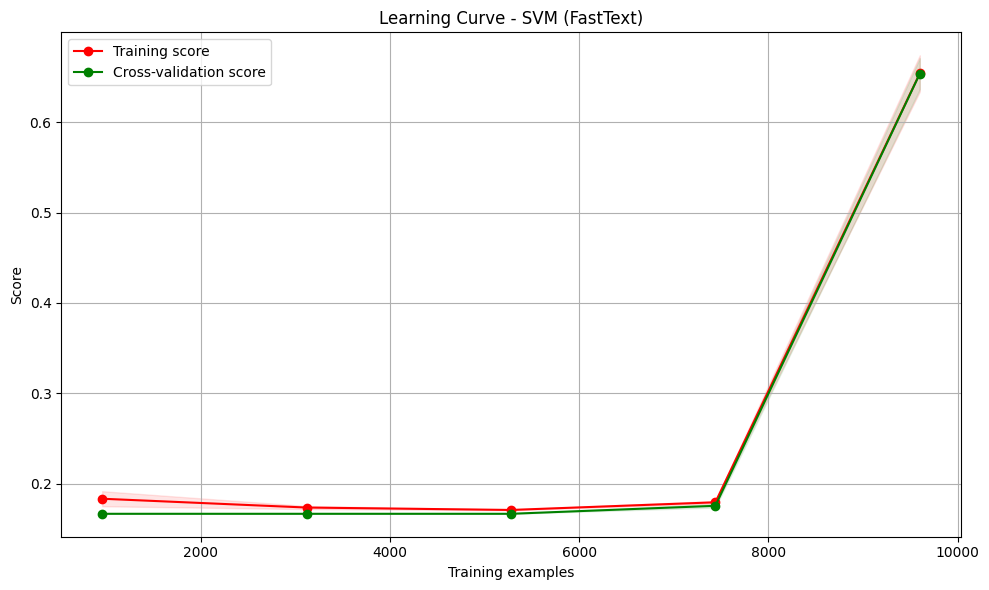


Generating ROC curves (one-vs-rest)...


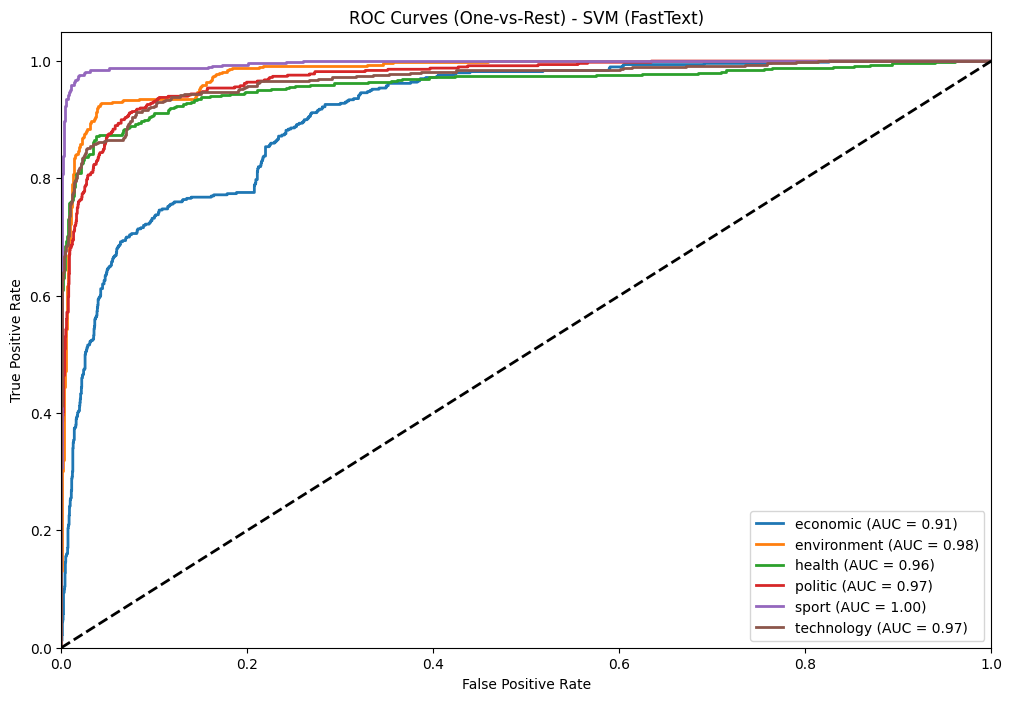


Training and evaluating MNB (FastText, shifted)...
CV accuracies: [0.84291667 0.86291667 0.84916667 0.86833333 0.84958333]
Mean CV accuracy: 0.8546 (±0.0095)
Training accuracy: 0.8552
Training completed in 0.31 seconds
MNB (FastText, shifted) model saved
Test Accuracy: 0.8620
Test Precision: 0.8740
Test Recall: 0.8620
Test F1 Score: 0.8651


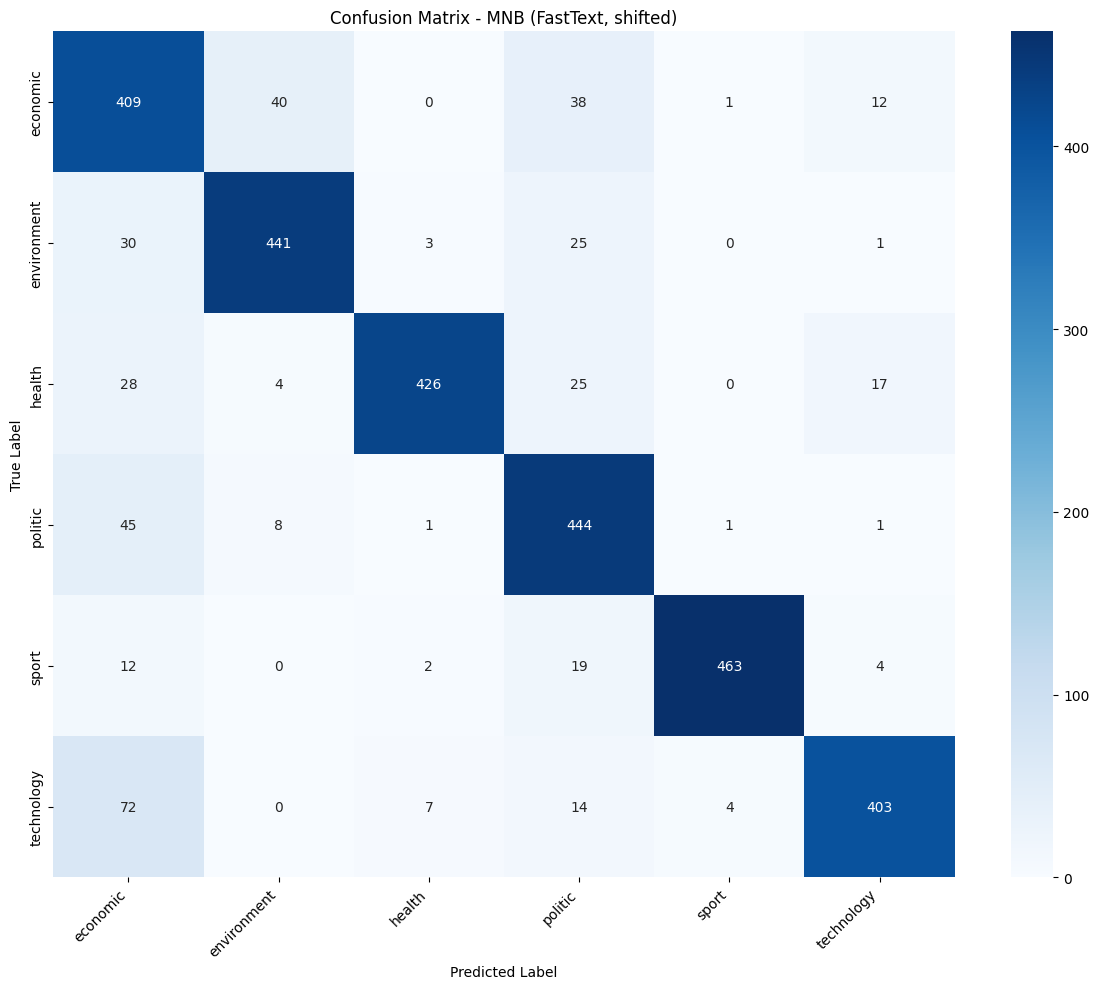


Classification Report:
              precision    recall  f1-score   support

    economic       0.69      0.82      0.75       500
 environment       0.89      0.88      0.89       500
      health       0.97      0.85      0.91       500
     politic       0.79      0.89      0.83       500
       sport       0.99      0.93      0.96       500
  technology       0.92      0.81      0.86       500

    accuracy                           0.86      3000
   macro avg       0.87      0.86      0.87      3000
weighted avg       0.87      0.86      0.87      3000


Generating learning curves...


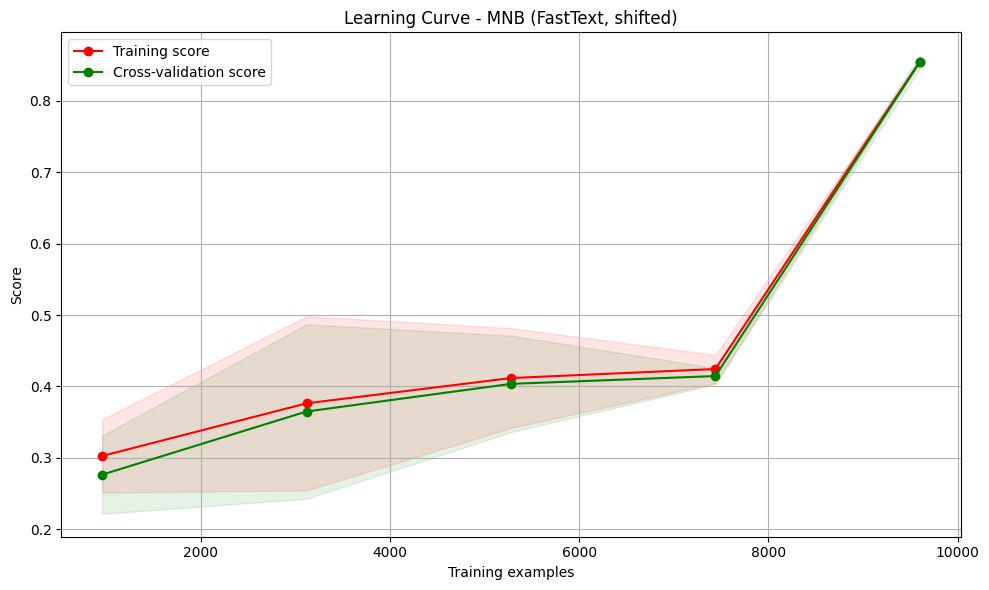


Generating ROC curves (one-vs-rest)...


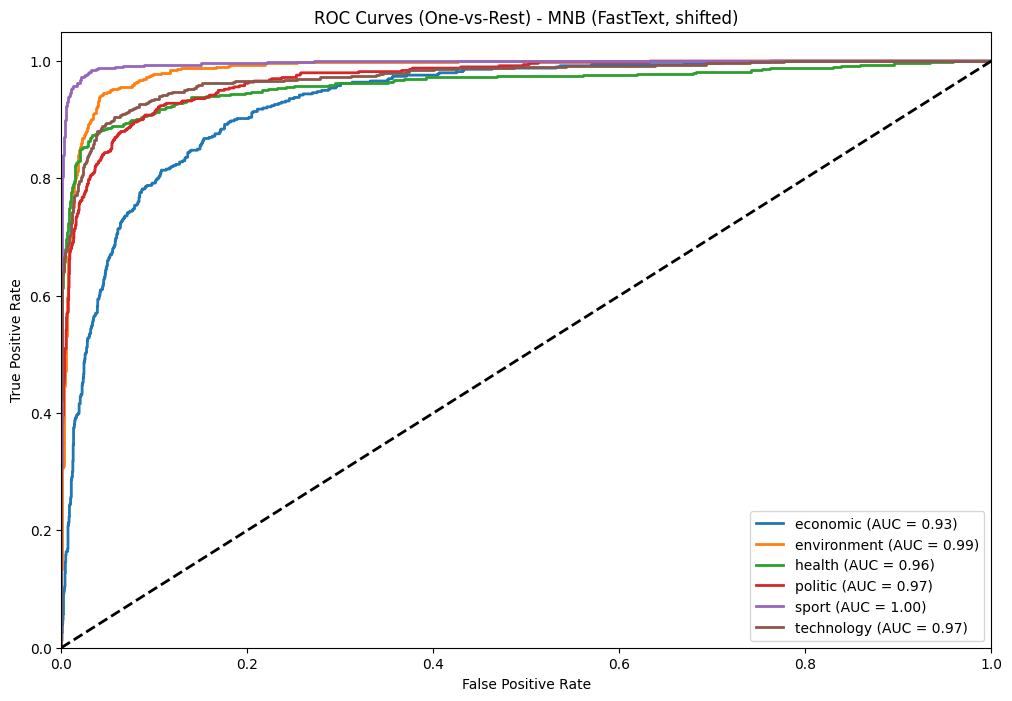


Model Comparison (FastText Features):
                model_name   cv_mean  accuracy  precision    recall        f1  \
0           SVM (FastText)  0.653583  0.671333   0.807214  0.671333  0.638963   
1  MNB (FastText, shifted)  0.854583  0.862000   0.874049  0.862000  0.865103   

   training_time  
0     658.294566  
1       0.305685  


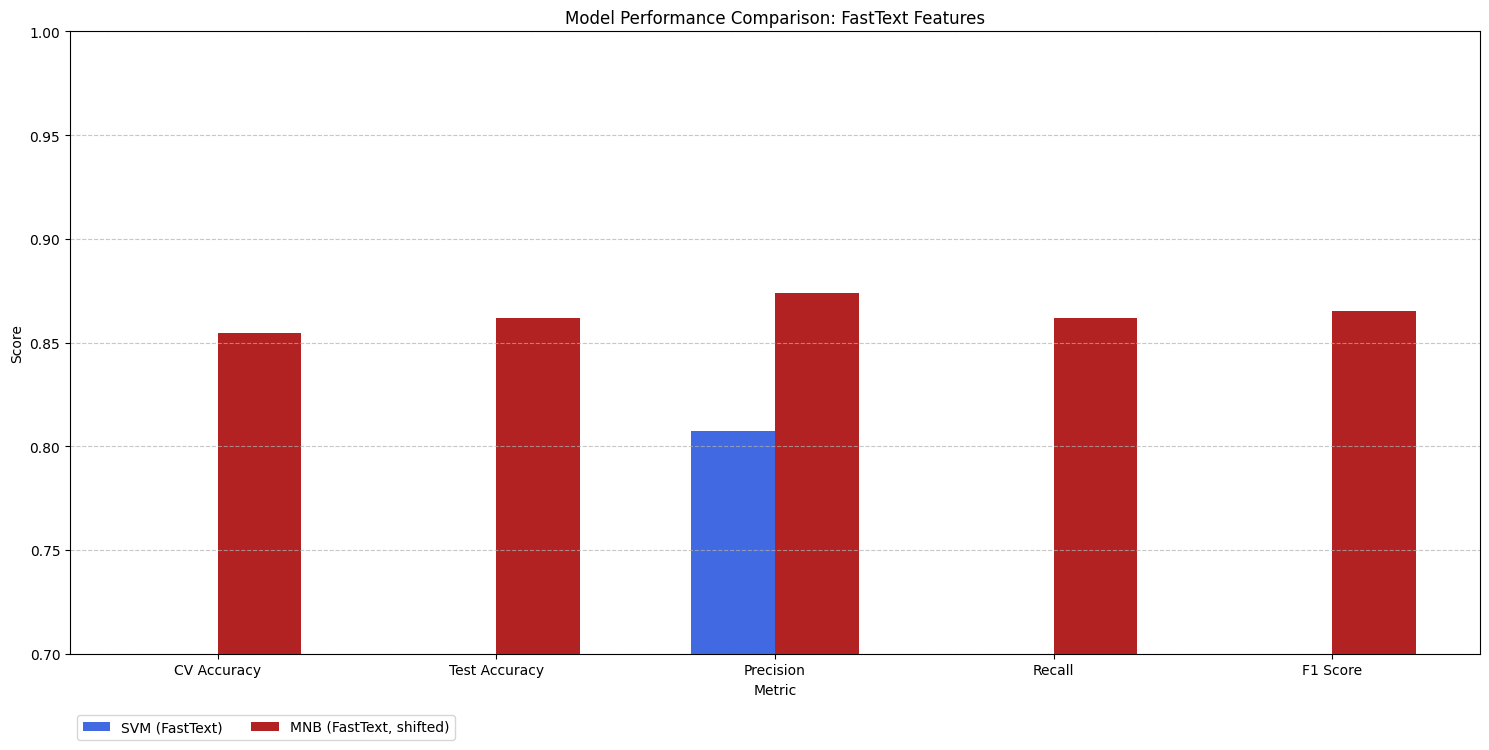

Best model (MNB (FastText, shifted)) saved for production use

Error Analysis for Best Model

Error Analysis for MultinomialNB
Found 414 misclassified instances out of 3000 test samples.

Categories with Highest Error Rates:
technology: 19.40% error rate (403/500 correctly classified)
economic: 18.20% error rate (409/500 correctly classified)
health: 14.80% error rate (426/500 correctly classified)
environment: 11.80% error rate (441/500 correctly classified)
politic: 11.20% error rate (444/500 correctly classified)
sport: 7.40% error rate (463/500 correctly classified)

Most Common Confusion Pairs (True -> Predicted):
technology -> economic: 72 instances
politic -> economic: 45 instances
economic -> environment: 40 instances
economic -> politic: 38 instances
environment -> economic: 30 instances
health -> economic: 28 instances
health -> politic: 25 instances
environment -> politic: 25 instances
sport -> politic: 19 instances
health -> technology: 17 instances

Training and Evaluation

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import joblib
import warnings
warnings.filterwarnings('ignore')

# Define paths
FASTTEXT_DIR = '/Users/socheata/Documents/FYP-Khmer-Classification/FastText_Features'
MODELS_DIR = '/Users/socheata/Documents/FYP-Khmer-Classification/Models/fasttext_models'
os.makedirs(MODELS_DIR, exist_ok=True)

# Load FastText features and labels
print("Loading FastText sentence embeddings and labels...")
X = np.load(os.path.join(FASTTEXT_DIR, 'sentence_embeddings.npy'))
y = np.load(os.path.join(FASTTEXT_DIR, 'labels.npy'), allow_pickle=True)
doc_ids = pd.read_csv(os.path.join(FASTTEXT_DIR, 'labels.csv'))['docId'].values

# Get unique categories from labels
categories = sorted(np.unique(y))
print(f"Loaded {X.shape[0]} samples with {X.shape[1]}-dim FastText features.")
print(f"Categories: {categories}")

# Split the data
X_train, X_test, y_train, y_test, doc_ids_train, doc_ids_test = train_test_split(
    X, y, doc_ids, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Shift FastText embeddings to be non-negative for MNB (not recommended for production)
X_train_shift = X_train - X_train.min()
X_test_shift = X_test - X_train.min()

# Function to generate learning curves
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=5, n_jobs=None, 
                        train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 6))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes.legend(loc="best")
    
    return plt

# Function to train and evaluate a model with cross-validation
def train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    print(f"\n{'='*50}")
    print(f"Training and evaluating {model_name}...")
    start_time = time.time()
    
    # 5-fold Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"CV accuracies: {cv_scores}")
    print(f"Mean CV accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    
    # Train the model on the full training set
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    print(f"Training accuracy: {train_accuracy:.4f}")
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Save the model
    joblib.dump(model, os.path.join(MODELS_DIR, f'{model_name.lower().replace(" ", "_")}.joblib'))
    print(f"{model_name} model saved")
    
    # Evaluate on test set
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=categories)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(MODELS_DIR, f"{model_name.lower().replace(' ', '_')}_confusion_matrix.png"))
    plt.show()
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=categories))
    
    # Generate learning curves
    print("\nGenerating learning curves...")
    plot_learning_curve(model, f'Learning Curve - {model_name}', X_train, y_train, cv=5)
    plt.tight_layout()
    plt.savefig(os.path.join(MODELS_DIR, f"{model_name.lower().replace(' ', '_')}_learning_curve.png"))
    plt.show()
    
    # ROC curves (One-vs-Rest)
    try:
        print("\nGenerating ROC curves (one-vs-rest)...")
        lb = LabelBinarizer()
        lb.fit(y)
        y_test_bin = lb.transform(y_test)
        if hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)
        else:
            y_score = model.predict_proba(X_test)
        
        # Calculate ROC curve and ROC area for each class
        fpr, tpr, roc_auc = {}, {}, {}
        n_classes = len(categories)
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Plot ROC curves
        plt.figure(figsize=(12, 8))
        
        # If there are many categories, plot only the first 10 for clarity
        if len(categories) > 10:
            for i, category in enumerate(categories[:10]):
                plt.plot(fpr[i], tpr[i], lw=2, label=f'{category} (AUC = {roc_auc[i]:.2f})')
        else:
            for i, category in enumerate(categories):
                plt.plot(fpr[i], tpr[i], lw=2, label=f'{category} (AUC = {roc_auc[i]:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves (One-vs-Rest) - {model_name}')
        plt.legend(loc="lower right")
        plt.savefig(os.path.join(MODELS_DIR, f"{model_name.lower().replace(' ', '_')}_roc_curves.png"))
        plt.show()
    except Exception as e:
        print(f"Warning: Could not generate ROC curves. Error: {e}")
    
    return {
        'model_name': model_name,
        'cv_scores': cv_scores,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'training_time': training_time,
        'train_accuracy': train_accuracy
    }

print("\n" + "="*80)
print("Training models on FastText features")
print("="*80)

# SVM (FastText)
svm_model = SVC(
    C=1,
    kernel='rbf',
    gamma=0.01,
    decision_function_shape='ovr',
    probability=True,
    random_state=42
)
svm_results = train_and_evaluate_model(
    "SVM (FastText)", svm_model, X_train, y_train, X_test, y_test
)

# MultinomialNB (FastText, shifted)
mnb_model = MultinomialNB()
mnb_results = train_and_evaluate_model(
    "MNB (FastText, shifted)", mnb_model, X_train_shift, y_train, X_test_shift, y_test
)

# Compare models
results = [svm_results, mnb_results]
model_comparison = pd.DataFrame(results)
print("\nModel Comparison (FastText Features):")
comparison_cols = ['model_name', 'cv_mean', 'accuracy', 'precision', 'recall', 'f1', 'training_time']
print(model_comparison[comparison_cols])

# Plot model comparison
metrics = ['cv_mean', 'accuracy', 'precision', 'recall', 'f1']
metric_labels = ['CV Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score']
model_names = [result['model_name'] for result in results]

plt.figure(figsize=(15, 8))
x = np.arange(len(metrics))
width = 0.3
colors = ['royalblue', 'firebrick']

for i, result in enumerate(results):
    values = [result[metric] for metric in metrics]
    plt.bar(x + (i-0.5)*width, values, width, label=result['model_name'], color=colors[i])

plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Model Performance Comparison: FastText Features')
plt.xticks(x, metric_labels)
plt.legend(loc='lower left', bbox_to_anchor=(0, -0.15), ncol=2)
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(os.path.join(MODELS_DIR, 'fasttext_model_comparison.png'))
plt.show()

# Save best model
all_accuracies = [svm_results['accuracy'], mnb_results['accuracy']]
best_model_idx = np.argmax(all_accuracies)
best_model_name = results[best_model_idx]['model_name']
best_model = svm_model if best_model_idx == 0 else mnb_model
joblib.dump(best_model, os.path.join(MODELS_DIR, 'best_model.joblib'))
print(f"Best model ({best_model_name}) saved for production use")

# Error analysis
def analyze_errors(model, X_test, y_test, categories, doc_ids_test, top_n=10):
    print(f"\n{'='*50}")
    print(f"Error Analysis for {model.__class__.__name__}")
    y_pred = model.predict(X_test)
    misclassified_indices = np.where(np.array(y_test) != np.array(y_pred))[0]
    if len(misclassified_indices) == 0:
        print("No misclassified instances found.")
        return
    print(f"Found {len(misclassified_indices)} misclassified instances out of {len(y_test)} test samples.")
    
    # Group errors by category
    errors_by_category = {}
    for idx in misclassified_indices:
        true_category = y_test[idx]
        pred_category = y_pred[idx]
        if true_category not in errors_by_category:
            errors_by_category[true_category] = []
        errors_by_category[true_category].append(pred_category)
    
    # Calculate error rates
    error_rates = {}
    for category in categories:
        category_count = sum(1 for y in y_test if y == category)
        if category_count == 0:
            continue
        misclassified_count = len(errors_by_category.get(category, []))
        error_rate = misclassified_count / category_count
        error_rates[category] = error_rate
    
    # Show categories with highest error rates
    print("\nCategories with Highest Error Rates:")
    sorted_categories = sorted(error_rates.items(), key=lambda x: x[1], reverse=True)
    for category, error_rate in sorted_categories[:top_n]:
        correct_count = sum(1 for y in y_test if y == category) - len(errors_by_category.get(category, []))
        total_count = sum(1 for y in y_test if y == category)
        print(f"{category}: {error_rate:.2%} error rate ({correct_count}/{total_count} correctly classified)")
    
    # Analyze confusion pairs
    confusion_pairs = {}
    for true_category, errors in errors_by_category.items():
        for pred_category in errors:
            pair = (true_category, pred_category)
            confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1
    
    print("\nMost Common Confusion Pairs (True -> Predicted):")
    sorted_pairs = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)
    for (true_cat, pred_cat), count in sorted_pairs[:top_n]:
        print(f"{true_cat} -> {pred_cat}: {count} instances")

print("\n" + "="*80)
print("Error Analysis for Best Model")
print("="*80)
if best_model_idx == 0:
    analyze_errors(svm_model, X_test, y_test, categories, doc_ids_test)
else:
    analyze_errors(mnb_model, X_test_shift, y_test, categories, doc_ids_test)

print("\n" + "="*80)
print("Training and Evaluation Complete!")
print("="*80)
print(f"All models saved in: {MODELS_DIR}")
print(f"Best model: {best_model_name}")
print("\nUse the following code to load and use the best model for prediction:")
print("```python")
print("import joblib")
print("# Load best model")
print("model = joblib.load('path/to/best_model.joblib')")
print("# For prediction:")
print("X_new = ... # shape (n_samples, 300) FastText embedding(s)")
print("if isinstance(model, MultinomialNB):  # For MNB")
print("    X_new = X_new - X_train.min()  # Apply the same shift as training")
print("y_pred = model.predict(X_new)")
print("# y_pred contains the predicted category labels")
print("```")